In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
import numpy as np
import prada
import pandas as pd
import veritas
import tree_compress
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=5)
plt.rc("lines", linewidth=1.0)

## Train models

In [3]:
dnames = ["Phoneme", "Banknote", "Spambase", "Credit", "California", "Mnist[2v4]", "Ijcnn1"]
param_dict = {
    "n_estimators": [50, 100],
    "learning_rate": [0.9, 0.5, 0.2],
    "subsample": [0.5, 0.9],
    "max_depth": [4, 6, 8],
}

In [4]:
best_models = {}
for dname in dnames:
    d = prada.get_dataset(dname, nfolds=5, silent=True, seed=12)
    d.load_dataset()
    d.robust_normalize()
    d.astype(np.float64)

    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    
    # `model_class` can be any sklearn compatible classifier.
    # There is built-in support for
    #   - rf:  sklearn RandomForest
    #   - xgb: xgboost
    #   - lgb: lightgbm
    model_type = "xgb" # or "rf", "lgb"
    model_class = d.get_model_class(model_type)

    models = []
    for i, params in enumerate(d.paramgrid(**param_dict)):
        clf, train_time = dtrain.train(xgb.XGBClassifier, params)
    
        mtrain = dtrain.metric(clf)
        mtest  = dtest.metric(clf)
        mvalid = dvalid.metric(clf)

        models.append((d, clf, mtrain, mtest, mvalid, params))

    d, clf, mtrain, mtest, mvalid, params = max(models, key=lambda m: m[3])

    best_models[dname] = (d, clf, mtrain, mtest, mvalid, params)
    print(f"BEST {dname:10s} train acc {mtrain*100:.1f}%, test acc {mtest*100:.1f}%")
    print("params", params)
    print()

BEST Phoneme    train acc 99.2%, test acc 90.6%
params {'n_estimators': 100, 'learning_rate': 0.2, 'subsample': 0.9, 'max_depth': 6}

BEST Banknote   train acc 100.0%, test acc 100.0%
params {'n_estimators': 50, 'learning_rate': 0.9, 'subsample': 0.9, 'max_depth': 4}

BEST Spambase   train acc 99.7%, test acc 95.3%
params {'n_estimators': 50, 'learning_rate': 0.5, 'subsample': 0.5, 'max_depth': 8}

BEST Credit     train acc 80.1%, test acc 77.7%
params {'n_estimators': 50, 'learning_rate': 0.2, 'subsample': 0.9, 'max_depth': 4}

BEST California train acc 97.1%, test acc 90.9%
params {'n_estimators': 100, 'learning_rate': 0.2, 'subsample': 0.9, 'max_depth': 6}

BEST Mnist[2v4] train acc 100.0%, test acc 99.6%
params {'n_estimators': 50, 'learning_rate': 0.5, 'subsample': 0.9, 'max_depth': 8}

BEST Ijcnn1     train acc 100.0%, test acc 99.3%
params {'n_estimators': 100, 'learning_rate': 0.5, 'subsample': 0.9, 'max_depth': 8}



## Compress the models using `tree_compress`

In [10]:
compressed_models = {}
for dname, (d, clf, mtrain, mtest, mvalid, params) in best_models.items():
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    data = tree_compress.Data(
        dtrain.X.to_numpy(), dtrain.y.to_numpy(),
        dtest.X.to_numpy(), dtest.y.to_numpy(),
        dvalid.X.to_numpy(), dvalid.y.to_numpy()
    )
    
    compressed_models[dname] = tree_compress.compress_topdown(
        data, clf, relerr=0.02, silent=True, max_rounds=2,
        return_compress_object=True
    )

    before = compressed_models[dname].records[0]
    after = compressed_models[dname].records[-1]
    print(f"{dname:10s} number of non-zero leaves: {before.nnz_leafs} -> {after.nnz_leafs},",
          f"test accuracy: {before.mtest*100:.1f}% -> {after.mtest*100:.1f}%")


| XGBOOST's base_score
|   base_score diff std      6.767112221160852e-07 OK
|   base_score reported      0.69284296
|   versus manually detected 0.8134442277854178
|   abs err                  0.1206012677854178
|   rel err                  0.1740672486380143
|   (!) base_score NOT THE SAME with relative tolerance 0.001

Phoneme    number of non-zero leaves: 2928 -> 109, test accuracy: 90.6% -> 88.3%

| XGBOOST's base_score
|   base_score diff std      1.9268317155183637e-06 OK
|   base_score reported      0.57230514
|   versus manually detected 0.29126331543026024
|   abs err                  0.28104182456973975
|   rel err                  0.4910698942346381
|   (!) base_score NOT THE SAME with relative tolerance 0.0005

Banknote   number of non-zero leaves: 161 -> 9, test accuracy: 100.0% -> 96.7%

| XGBOOST's base_score
|   base_score diff std      3.5518757340256144e-07 OK
|   base_score reported      0.39492488
|   versus manually detected -0.4266570159118273
|   abs err       

## Plot the results

An open issue: ijcnn1 is an imbalanced dataset. The drop of 2% of accuracy is more severe for ijcnn1 than for the other datasets.
We should be able to configure:

- custom metric to choose alpha
- use class weights in linear classifier

We could, of course, also use a lower `relerr` for ijcnn1, but we are using the same value for all datasets here.

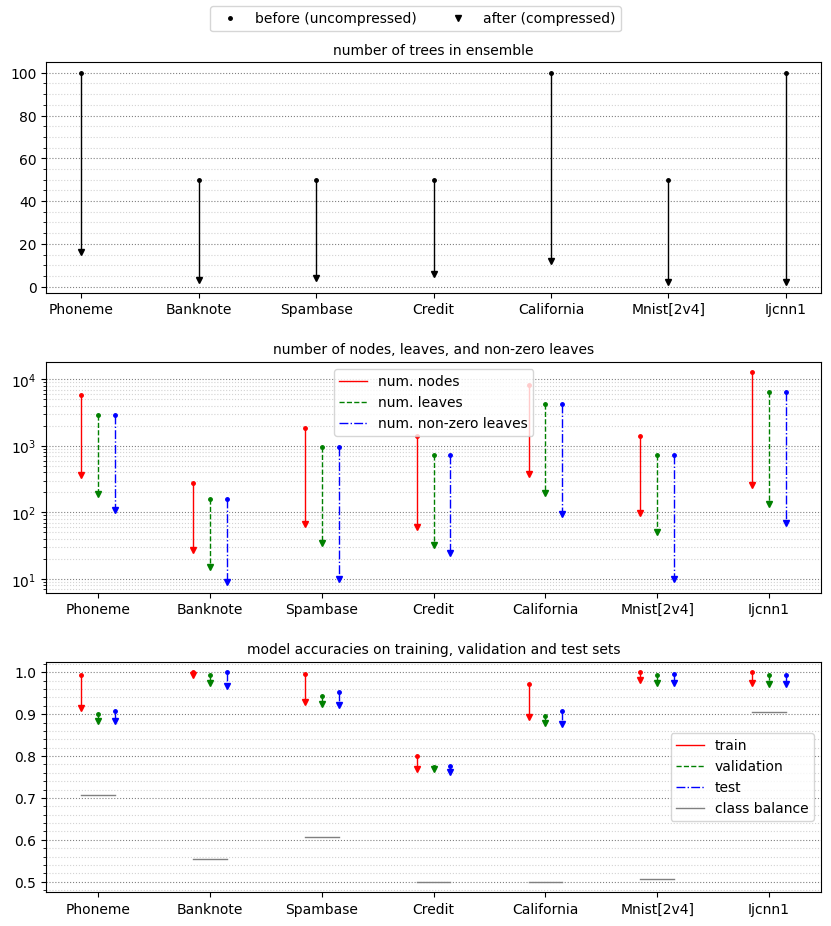

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].set_prop_cycle(color=['black'])
for k in [1, 2]:
    axs[k].set_prop_cycle(color=['red', 'green', 'blue'])

#for k, (dname, c) in enumerate(compressed_models.items()):
for k, dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(range(len(compressed_models)), compressed_models.keys(), compressed_models.values(), best_models.values()):
    before = c.records[0]
    after = c.records[-1]

    i = k-0.15
    j = k+0.15
    
    lk, = axs[0].plot(k, before.ntrees, ".")
    axs[0].plot(k, after.ntrees, "v", color=lk.get_color())
    axs[0].plot([k, k], [before.ntrees, after.ntrees],
                color=lk.get_color())
    
    li, = axs[1].plot(i, before.nnodes, ".")
    axs[1].plot(i, after.nnodes, "v", color=li.get_color())
    axs[1].plot([i, i], [before.nnodes, after.nnodes], "-",
                color=li.get_color())
    
    lk, = axs[1].plot(k, before.nleafs, ".")
    axs[1].plot(k, after.nleafs, "v", color=lk.get_color())
    axs[1].plot([k, k], [before.nleafs, after.nleafs], "--",
                color=lk.get_color())

    lj, = axs[1].plot(j, before.nnz_leafs, ".")
    axs[1].plot(j, after.nnz_leafs, "v", color=lj.get_color())
    axs[1].plot([j, j], [before.nnz_leafs, after.nnz_leafs], "-.",
                color=lj.get_color())
    
    li, = axs[2].plot(i, before.mtrain, ".")
    axs[2].plot(i, after.mtrain, "v", color=li.get_color())
    axs[2].plot([i, i], [before.mtrain, after.mtrain], "-",
                color=li.get_color())
    
    lk, = axs[2].plot(k, before.mvalid, ".")
    axs[2].plot(k, after.mvalid, "v", color=lk.get_color())
    axs[2].plot([k, k], [before.mvalid, after.mvalid], "--",
                color=lk.get_color())

    lj, = axs[2].plot(j, before.mtest, ".")
    axs[2].plot(j, after.mtest, "v", color=lj.get_color())
    axs[2].plot([j, j], [before.mtest, after.mtest], "-.",
                color=lj.get_color())

    class_balance = d.y.mean()
    class_balance = max(1-class_balance, class_balance)
    axs[2].plot([i, j], [class_balance, class_balance], "-", c="gray")

for k in [0, 1, 2]:
    axs[k].set_xticks(range(len(compressed_models)))
    axs[k].set_xticklabels(list(compressed_models.keys()))
    axs[k].grid(visible=True, axis="y", ls=":", color="gray", which="major")
    axs[k].grid(visible=True, axis="y", ls=":", color="lightgray", which="minor")

fig.legend([
                Line2D([0], [0], c="black", ls="", marker="."),
                Line2D([0], [0], c="black", ls="", marker="v")
           ], [
                "before (uncompressed)",
                "after (compressed)"
           ], loc="upper center", ncols=2)

axs[1].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
           ], [
                "num. nodes",
                "num. leaves",
                "num. non-zero leaves",
           ])

axs[2].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
                Line2D([0], [0], c="gray", ls="-"),
           ], [
                "train",
                "validation",
                "test",
                "class balance",
           ])

axs[0].set_title("number of trees in ensemble")
axs[1].set_title("number of nodes, leaves, and non-zero leaves")
axs[2].set_title("model accuracies on training, validation and test sets")

axs[1].set_yscale("log")
axs[0].yaxis.set_minor_locator(MultipleLocator(5))
axs[2].yaxis.set_minor_locator(MultipleLocator(0.02))

fig.subplots_adjust(top=0.94, hspace=0.3)

plt.show()

In [21]:
# Tabulate
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
df = pd.DataFrame("-", columns=["train", "validation", "test", "ntrees", "nnodes", "nleaves", "nnz_leaves"], index=index_acc)

for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    rbefore = df.loc[(dname, "before"), :]
    rafter = df.loc[(dname, "after"), :]

    rbefore["train"] = np.round(before.mtrain*100, 1)
    rafter["train"] = np.round(after.mtrain*100, 1)
    rbefore["validation"] = np.round(before.mvalid*100, 1)
    rafter["validation"] = np.round(after.mvalid*100, 1)
    rbefore["test"] = np.round(before.mtest*100, 1)
    rafter["test"] = np.round(after.mtest*100, 1)

    rbefore["ntrees"] = before.ntrees
    rafter[ "ntrees"] = after.ntrees
    rbefore["nnodes"] = before.nnodes
    rafter[ "nnodes"] = after.nnodes
    rbefore["nleaves"] = before.nleafs
    rafter[ "nleaves"] = after.nleafs
    rbefore["nnz_leaves"] = before.nnz_leafs
    rafter[ "nnz_leaves"] = after.nnz_leafs

display(df)

train validation   test ntrees nnodes nleaves nnz_leaves
Phoneme    before   99.2       90.1   90.6    100   5756    2928       2928
           after    91.6       88.3   88.3     16    366     191        109
Banknote   before  100.0       99.3  100.0     50    272     161        161
           after    99.4       97.4   96.7      3     27      15          9
Spambase   before   99.7       94.2   95.3     50   1842     946        946
           after    92.9       92.4   92.3      4     66      35         10
Credit     before   80.1       77.4   77.7     50   1394     722        722
           after    76.9       76.9   76.3      6     60      33         25
California before   97.1       89.6   90.9    100   8262    4181       4179
           after    89.4       87.8   87.5     12    378     195         94
Mnist[2v4] before  100.0       99.3   99.6     50   1404     727        727
           after    98.2       97.4   97.5      2     98      50         10
Ijcnn1     before  100.0       99.3   99.3    100  12640    6370       6370
           after    97.4       97.3   97.2      2    262     132         70

## Verifiability: how many OCs?

If we can enumerate all the OCs in 60 seconds, then we consider the models tractably verifiable.

In [13]:
for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    display(HTML(f"<b>{dname}<b>"))
    at_pruned = after.at

    config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
    config.stop_when_optimal = False
    search = config.get_search(at_pruned)

    while search.steps(1000) != veritas.StopReason.NO_MORE_OPEN \
            and search.time_since_start() < 60.0:
        pass
        #print("Veritas", search.num_solutions(), search.num_open())
    print("Number of OCs", search.num_solutions())
    print("Number of unexplored open states (should be 0)", search.num_open())


Number of OCs 201239
Number of unexplored open states (should be 0) 0


Number of OCs 37
Number of unexplored open states (should be 0) 0


Number of OCs 3259
Number of unexplored open states (should be 0) 0


Number of OCs 194
Number of unexplored open states (should be 0) 0


Number of OCs 129696
Number of unexplored open states (should be 0) 0


Number of OCs 280
Number of unexplored open states (should be 0) 0


Number of OCs 932
Number of unexplored open states (should be 0) 0


## Checking robustness on the test set

We compute the adversarial accuracy on the original model, and on the pruned model.
We ask the questions:

- How much faster can we do this on the pruned dataset?
- How does pruning affect the robustness of the models?

In [31]:
delta = 0.05
robustness = {}

for dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(compressed_models.keys(), compressed_models.values(), best_models.values()):
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    before = c.records[0]
    after = c.records[-1]

    #print()
    #veritas.test_conversion(before.at, dtest.X.to_numpy(), clf.predict_proba(dtest.X)[:,1])

    display(HTML(f"<b>{dname}<b>"))

    total_time = [0.0, 0.0]
    count = [0, 0]
    count_wrong = [0, 0]
    count_nonrobust = [0, 0]
    count_to = [0, 0]

    for i in range(min(2000, dtest.X.shape[0])):
        example = dtest.X.iloc[i, :].to_numpy()
        true_label = int(dtest.y.iloc[i])
        prune_box = [veritas.Interval(x-delta, x+delta) for x in example]

        for k, at in enumerate([before.at, after.at]):
            count[k] += 1
            pred_label = int(at.predict(example)[0][0] >= .5)
    
            if true_label != pred_label:
                count_wrong[k] += 1
                continue
    
            heur = veritas.HeuristicType.MIN_OUTPUT if pred_label \
                   else veritas.HeuristicType.MAX_OUTPUT
    
            config = veritas.Config(heur)
            config.ignore_state_when_worse_than = 0.0
            search = config.get_search(at, prune_box)
    
            stop_reason = veritas.StopReason.NONE
        
            while search.num_solutions() == 0 \
                    and stop_reason == veritas.StopReason.NONE \
                    and search.time_since_start() < 5.0:
                stop_reason = search.steps(1000)
    
            total_time[k] += search.time_since_start()
    
            raw_pred = 0.0
            if search.num_solutions() > 0:
                adv_example = veritas.get_closest_example(search.get_solution(0), example, 1e-4)
                wrong_label = int(at.predict(adv_example)[0][0] >= .5)
                #data = np.vstack([example.reshape(1, -1), adv_example.reshape(1, -1)])
                #raw_pred_example, raw_pred_adv = at.eval(data)[:, 0]
                assert wrong_label != pred_label
                count_nonrobust[k] += 1
            if search.time_since_start() >= 5.0:
                count_to[k] += 1
        
        #print(i, f"lab={label}, adv={wrong_label} {raw_pred:5.3f}", search.num_solutions())
    print(f"TOTAL TIME before {total_time[0]:.4f}s after {total_time[1]:.4f}s",
          f"({total_time[0]/total_time[1]:.1f}x)")
    print(f"ROBUSTNESS before nonrobust {count_nonrobust[0]:4d}, incorrect {count_wrong[0]:4d}, timeout {count_to[0]:4d} ({count[0]})",
          f"adv acc={100*(1.0-(count_nonrobust[0]+count_wrong[0])/(count[0])):.1f}%")
    print(f"            after nonrobust {count_nonrobust[1]:4d}, incorrect {count_wrong[1]:4d}, timeout {count_to[1]:4d} ({count[1]})",
          f"adv acc={100*(1.0-(count_nonrobust[1]+count_wrong[1])/(count[1])):.1f}%")

    robustness[dname] = [{
        "total_time": total_time[k],
        "count_nonrobust": count_nonrobust[k],
        "count_wrong": count_wrong[k],
        "count_to": count_to[k],
        "count": count[k],
    } for k in range(2)]

TOTAL TIME before 1.4837s after 0.0481s (30.9x)
ROBUSTNESS before nonrobust  432, incorrect  101, timeout    0 (1080) adv acc=50.6%
            after nonrobust  315, incorrect  126, timeout    0 (1080) adv acc=59.2%


TOTAL TIME before 0.0069s after 0.0028s (2.5x)
ROBUSTNESS before nonrobust   11, incorrect    0, timeout    0 (274) adv acc=96.0%
            after nonrobust   23, incorrect    9, timeout    0 (274) adv acc=88.3%


TOTAL TIME before 0.7624s after 0.0174s (43.9x)
ROBUSTNESS before nonrobust  460, incorrect   43, timeout    0 (920) adv acc=45.3%
            after nonrobust  132, incorrect   71, timeout    0 (920) adv acc=77.9%


TOTAL TIME before 0.1445s after 0.0204s (7.1x)
ROBUSTNESS before nonrobust  347, incorrect  452, timeout    0 (2000) adv acc=60.1%
            after nonrobust  138, incorrect  479, timeout    0 (2000) adv acc=69.2%


TOTAL TIME before 6.4317s after 0.0841s (76.5x)
ROBUSTNESS before nonrobust  993, incorrect  182, timeout    0 (2000) adv acc=41.2%
            after nonrobust  612, incorrect  246, timeout    0 (2000) adv acc=57.1%


TOTAL TIME before 9.0063s after 0.1508s (59.7x)
ROBUSTNESS before nonrobust  731, incorrect    7, timeout    0 (2000) adv acc=63.1%
            after nonrobust 1073, incorrect   49, timeout    0 (2000) adv acc=43.9%


TOTAL TIME before 4.5059s after 0.0716s (62.9x)
ROBUSTNESS before nonrobust  193, incorrect   14, timeout    0 (2000) adv acc=89.6%
            after nonrobust  107, incorrect   53, timeout    0 (2000) adv acc=92.0%


In [33]:
# Tabulate
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
dfrob = pd.DataFrame("-", columns=["wrong", "nonrobust", "total", "adv.acc", "time", "speedup"], index=index_acc)

for k, (dname, results) in enumerate(robustness.items()):
    before = c.records[0]
    after = c.records[-1]

    for j, jj, res in zip(range(2), ["before", "after"], results):
        r = dfrob.loc[(dname, jj), :]
        rafter = dfrob.loc[(dname, "after"), :]

        r["wrong"] = res["count_wrong"]
        r["nonrobust"] = res["count_nonrobust"]
        r["total"] = res["count"]
        #r["timeout"] = res["count_to"]
        r["adv.acc"] = np.round(100.0 - 100*(res["count_wrong"] + res["count_nonrobust"]) / res["count"], 1)
        r["time"] = np.round(res["total_time"], 2)

    dfrob.loc[(dname, "after"), "speedup"] = np.round(results[0]["total_time"] / results[1]["total_time"], 1)

display(dfrob)

wrong nonrobust total adv.acc  time speedup
Phoneme    before   101       432  1080    50.6  1.48       -
           after    126       315  1080    59.2  0.05    30.9
Banknote   before     0        11   274    96.0  0.01       -
           after      9        23   274    88.3   0.0     2.5
Spambase   before    43       460   920    45.3  0.76       -
           after     71       132   920    77.9  0.02    43.9
Credit     before   452       347  2000    60.0  0.14       -
           after    479       138  2000    69.2  0.02     7.1
California before   182       993  2000    41.2  6.43       -
           after    246       612  2000    57.1  0.08    76.5
Mnist[2v4] before     7       731  2000    63.1  9.01       -
           after     49      1073  2000    43.9  0.15    59.7
Ijcnn1     before    14       193  2000    89.6  4.51       -
           after     53       107  2000    92.0  0.07    62.9